In [0]:
# all config/downloads to use fastai
!pip install pandas --upgrade
!pip install plotly --upgrade
!pip install fastai==0.7.0
!pip install torchtext==0.2.3
!pip install torch
!pip install torchvision
!pip install Pillow>=4.1.1
!pip install image
!pip install matplotlib
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (3.7.0)


In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Find the data within the drive environment to be loaded into pandas**

In [0]:
PATH = "/content/"

In [0]:
!unzip drive/'My Drive'/fastai/hetrec2011-lastfm-2k.zip

Archive:  drive/My Drive/fastai/hetrec2011-lastfm-2k.zip
  inflating: user_friends.dat        
  inflating: user_taggedartists.dat  
  inflating: user_taggedartists-timestamps.dat  
  inflating: artists.dat             
  inflating: readme.txt              
  inflating: tags.dat                
  inflating: user_artists.dat        


In [0]:
import pandas as pd

In [0]:
df = pd.read_csv(PATH + 'user_artists.dat', sep='\s+')

In [0]:
# save file to a csv that is located within the fastai drive folder
PATH = "/content/drive/My Drive/fastai/"
df.to_csv(PATH + "music_ratings.csv")

In [0]:
# read in df from the new csv file
PATH = "/content/drive/My Drive/fastai/"
df = pd.read_csv(PATH + "music_ratings.csv").iloc[:, 1:]

In [0]:
df.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


Check for any null values or missing values within the given data set, as well as how many unique users/artists there are, to determine density of the data set

In [0]:
df.isnull().any().any()

False

In [0]:
# check number of unique user/artist IDs
unique_users = df.loc[:, "userID"].nunique()
unique_users

1892

In [0]:
unique_artists = df.loc[:, "artistID"].nunique()
unique_artists

17632

In [0]:
total_entries = df.shape[0]

In [0]:
total_entries/(unique_users*unique_artists)

0.002782815119924182

As can be seen above, this dataset is pretty sparse ~.2% denisity. So, probably should use matrix factorization approach to CF - latent factors within matrix are good approach to more sparse data sets. If it doesn't work well, may also use Factorization machine. 

In [0]:
# I have a theory that many songs are highly rated and the majority of artists are just random combinations of artists with only a few ratings
# observe how many of each artist rating there are maybe, a few of the very random artists/combinations can be filtered
grouped_df = df.groupby('artistID', as_index=False).count().iloc[:, :2].sort_values('userID', ascending=False)
print(grouped_df.shape)
grouped_df = grouped_df[grouped_df.userID > 1]
grouped_df.shape

(17632, 2)


(6953, 2)

As can be seen above, 10K of these artists are just artists that were rated once, this could be something to consider filtering in future to improve density of model. With only one, rating, the effectiveness of matrix factorization might suffer because finding an embedding for this particular artist will be extremely biased toward the one user's opinion

**Need to check if userID and artistID values are contiguous**

In [0]:
# find the maximum userID
df.sort_values('userID', ascending=False).iloc[1, :]

userID      2100
artistID    1276
weight      1133
Name: 92795, dtype: int64

In [0]:
# find maximum artistID
df.sort_values('artistID', ascending=False).iloc[1, :]

userID        454
artistID    18744
weight        286
Name: 20917, dtype: int64

IDs for artists and users are clearly not contiguous, may want to change this later and store mapping in a dictionary to simplify lookup within the embedding matrices for users and artists

In [0]:
# convert rating column to floats
df_scaled = copy.deepcopy(df)
df_scaled.loc[:, ["weight"]] = df_scaled.weight.astype('float64')

In [0]:
df_scaled.dtypes

userID        int64
artistID      int64
weight      float64
dtype: object

In [0]:
# perform feature scaling on the data set
mean = df_scaled.weight.mean()
std = df_scaled.weight.std()
print(mean)
print(std)

745.2439300256372
3751.322080387676


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12a51e7320>]], dtype=object)

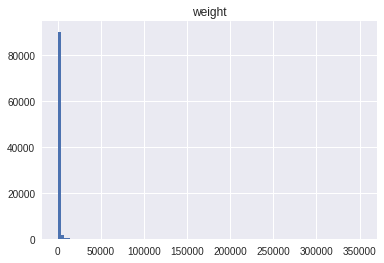

In [0]:
# visualize the current weights to check for weird values/outliers
df[["weight"]].hist(bins=100)

This visualization clearly shows that there are some peculiar outliers in this data set - the majority of values are within a certain range, while a few values are far away. The mean of the data is 745, but there are some values that are up to 30,000 in weight, must check how many peculiar outliers like this exist

In [0]:
filter = 10000
print(f"Total ratings: {df.weight.count()}")
print(f"Total ratings under {filter}: {df[df.weight < filter].weight.count()}")

Total ratings: 92834
Total ratings under 10000: 92203


This test of outliers shows that there is a significant amount of data that is far away from the average. Therefore, these outliers cannot just be eliminated from the data set - there is a significant amount of data that falls away from the average on the higher end - this may be the super popular artists that have much more listens/fans than normal artists. 

Could consider normalizing the data on the samples closer to the mean, so that the mean is not so significantly manipulated by these outliers. They cause the distribution of normalized data to have a really large tail and not be centered well around 0.

In [0]:
df_scaled[["weight"]] = df_scaled["weight"].apply(lambda x: (x - mean)/std )

In [0]:
df_scaled.sort_values("weight").tail()

,userID,artistID,weight
73745,1664,498,60.534327
84249,1905,203,68.571227
49304,1094,511,85.297863
91659,2071,792,86.347626
72739,1642,72,93.820991


In [0]:
df_scaled.to_csv(PATH + 'music_ratings_normalized.csv')

The loss was not great in the model with this raw, but normalized data. So, I am going to filter out the artists that are seen <= 2 times and see if this includes the performance of the model. The density of ratings is very bad, which is probably a result of random artists that were only rated a few times 

In [0]:
# create list of 
MIN_RATINGS = 5
grouped_df = df.groupby('artistID', as_index=False).count().iloc[:, :2].sort_values('userID', ascending=False)
grouped_df = grouped_df.loc[grouped_df["userID"] >= MIN_RATINGS]
grouped_df.columns = ['artistID', 'num_ratings']
filtered_df = df.merge(grouped_df, how='inner', on='artistID')

grouped_df.tail()

,artistID,num_ratings
159,165,5
212,218,5
33,38,5
6230,6362,5
8500,8706,5


In [0]:
# join two dataframes so that artists with few ratings are eliminated
filtered_df = df.merge(grouped_df, how='inner', on='artistID')
#filtered_df.sort_values('num_ratings', ascending=False).tail()
filtered_df.head()

,userID,artistID,weight,num_ratings
0,2,51,13883,111
1,4,51,228,111
2,27,51,85,111
3,28,51,10,111
4,62,51,528,111


Now, the density of the data set can be checked again to make sure that is is more reasonable for fitting the matrix factorization model

In [0]:
# check number of unique user/artist IDs
unique_users = filtered_df.loc[:, "userID"].nunique()
unique_artists = filtered_df.loc[:, "artistID"].nunique()
total_entries = filtered_df.shape[0]
print(total_entries/(unique_users*unique_artists))

0.013427282577881849


As can be seen, the density of the data set is not 1.5% instead of .2%, which is much more reasonable for training an accurate collaborative filtering model. Now the data can be normalized on this set and sent to a csv for a model to be trained.

In [0]:
print(df_scaled.shape)
print(filtered_df.shape)

(92834, 3)
(71426, 4)


In [0]:
# normalize the data within the new filtered set
mean = filtered_df.weight.mean()
std = filtered_df.weight.std()
filtered_df[["weight"]] = filtered_df["weight"].apply(lambda x: (x-mean)/std)


mean = df.weight.mean()
std = df.weight.std()
df[["weight"]] = df["weight"].apply(lambda x: (x-mean)/std)

In [0]:
# remove the num_ratings column from the data frame because it is not needed
filtered_df = filtered_df.iloc[:, :-1]
filtered_df.head()

,userID,artistID,weight
0,2,51,3.075474
1,4,51,-0.145151
2,27,51,-0.178878
3,28,51,-0.196568
4,62,51,-0.074394


In [0]:
filtered_df.sort_values("weight").tail()

,userID,artistID,weight
25922,1664,498,53.536102
7533,1905,203,60.646950
26546,1094,511,75.446259
34893,2071,792,76.375063
2253,1642,72,82.987310


In [0]:
# send the current scaled and filtered model to a csv file
filtered_df.to_csv(PATH + "music_ratings_filtscale.csv")

In [0]:
filtered_df = pd.read_csv(PATH + 'music_ratings_filtscale.csv').iloc[:, 1:]
filtered_df.head()

,userID,artistID,weight
0,2,51,3.075474
1,4,51,-0.145151
2,27,51,-0.178878
3,28,51,-0.196568
4,62,51,-0.074394


Now that we have trained a decent model, we can build it from scratch and try to make it better

In [0]:
# must make ID values contiguous so they can be used for lookup into a table
contig_df = copy.deepcopy(filtered_df)

# make the userID and artist IDs unique and contiguous
unique_users = contig_df.userID.unique()
user_to_index_dict = {o: i for i, o in enumerate(unique_users)}
index_to_user_dict = {i: o for i, o in enumerate(unique_users)}
contig_df.userID = contig_df.userID.apply(lambda x: user_to_index_dict[x])
unique_artists = contig_df.artistID.unique()
artist_to_index_dict = {o: i for i, o in enumerate(unique_artists)}
index_to_artist_dict = {i: o for i, o in enumerate(unique_artists)}
contig_df.artistID = contig_df.artistID.apply(lambda x: artist_to_index_dict[x])

NameError: ignored

In [0]:
# ensure the correct number of contiguous user and artist IDs
contig_df.sort_values('userID').head()

NameError: ignored

In [0]:
# write user/artists dictionaries to files so that the mappings can be used later when studying the resulting model
import pickle
pickle.dump(user_to_index_dict, open(PATH + "user_to_index_dict.txt", "wb"))
pickle.dump(index_to_user_dict, open(PATH + "index_to_user_dict.txt", "wb"))
pickle.dump(artist_to_index_dict, open(PATH + "artist_to_index_dict.txt", "wb"))
pickle.dump(index_to_artist_dict, open(PATH + "index_to_artist_dict.txt", "wb"))

In [0]:
# randomize order of the df and write to a csv
contig_df = contig_df.sample(frac=1)
contig_df.to_csv(PATH + "music_ratings_contig.csv", index=False)